In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

This present notebook explores some of the data that can be obtained from gapminder.com, using several indicators across time to elucidate relationships, clusters, and longitudinal changes. The structure will be as such:
> 1. K-means clustering of the countries of the world, first by 'Babies per Woman', and then by Human Development Index (HDI).
> 2. Silhouette analysis will then be conducted to ascertain the optimum number of clusters to use for accurate mapping and visualisation.
> 3. Chloropleth mapping of the clusters will allow visual juxtaposition of the parts of the world in terms of babies per woman and in terms of HDI, in order to gain a preliminary insight in to the extent to which the two metrics are related.
> 4. Principal component analysis (PCA) will then be conducted to allow further visualisation of all of the features available in the curated data set at a reduced dimensionality.
> 5. A correlation matrix will be visualised between all of the variables in order to get a better sense of which factors are related to each other, advising on which variables are to be taken forward to the predictive modelling stage and also providing insight in of itself.
> 6. Exploratory data analysis (EDA) will be conducted on the data to communicate what preparation needs to be done to the data before inputting in to a linear regression model which will be able to predict HDI.
> 7. Finally, a linear regression is created, tested, and validated.

In [2]:
plt.style.use('seaborn')

# reading in the main dataframe with all of the features together, save for hdi, and merging with hdi, as hdi data
# goes back far fewer years, starting in the 1990's.

df = pd.read_csv('all_merged_data.csv')
hdi = pd.read_csv('hdi_clustering.csv', index_col = 0)
df = df.loc[df.year >=1900]
df = pd.merge(df, hdi, how = 'inner', on = ['country', 'year'])

# selecting the present year and relevant features for clustering and chloropleth mapping
ndfeatures = df.loc[df.year == 2018]
ndfeatures = ndfeatures[['birth rate', 'child mortality', 'gdp_per_capita', 'life expectancy', 'hdi']]

## K-Means clustering and silhouette analysis

Several numbers of clusters will be tested on the babies per woman data as well as the human development index data in order to ascertain the optimum number of clusters to fit the data and to filter by on a chloropleth map, for visual comparison to see if an initial, ostensible relationship between the two can be observed.

In [228]:
# reading in the birth rate df for clustering and silhouette analysis

birthrateclustering = pd.read_csv('clusteringdf.csv', index_col = 0)
mappingdf = birthrateclustering.loc[birthrateclustering.year == 2018]
birthrate = mappingdf['birth rate']

In [229]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

For n_clusters = 3 The average silhouette_score is : 0.612227388638036
For n_clusters = 4 The average silhouette_score is : 0.605847405056607
For n_clusters = 5 The average silhouette_score is : 0.5999452984064488
For n_clusters = 6 The average silhouette_score is : 0.5491623859299263


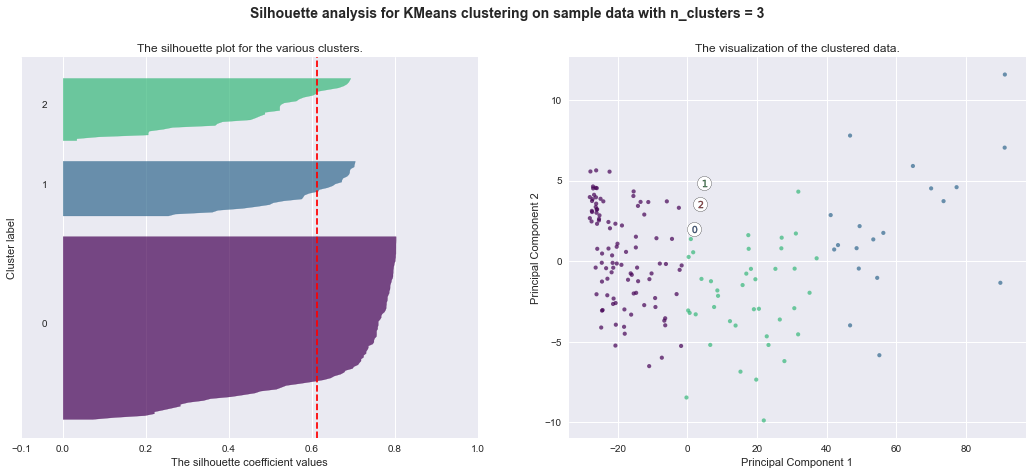

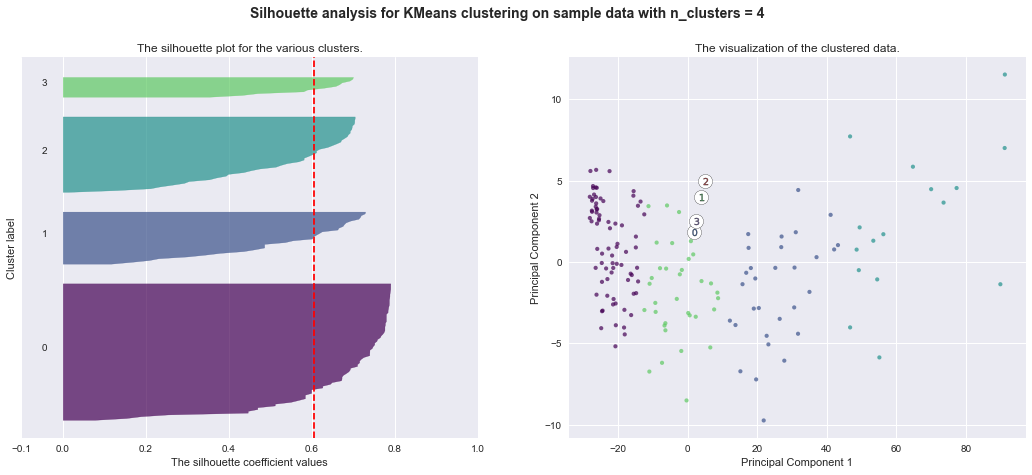

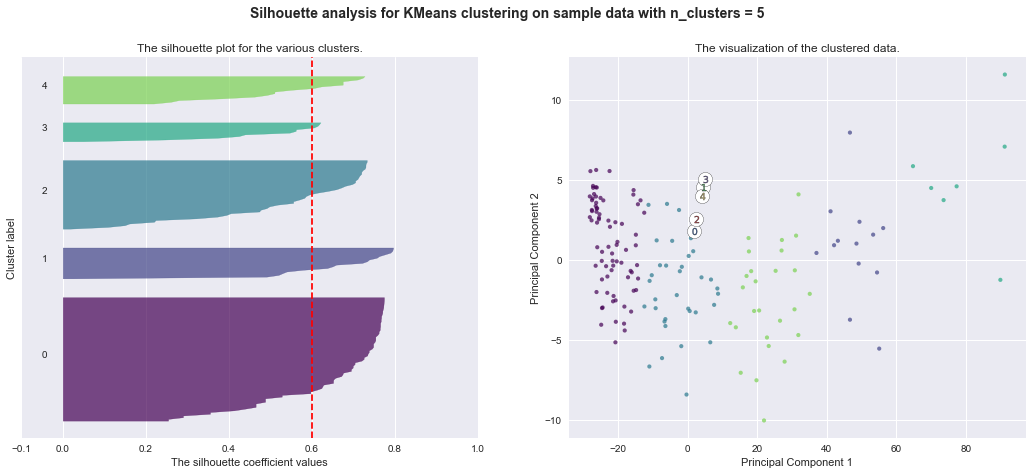

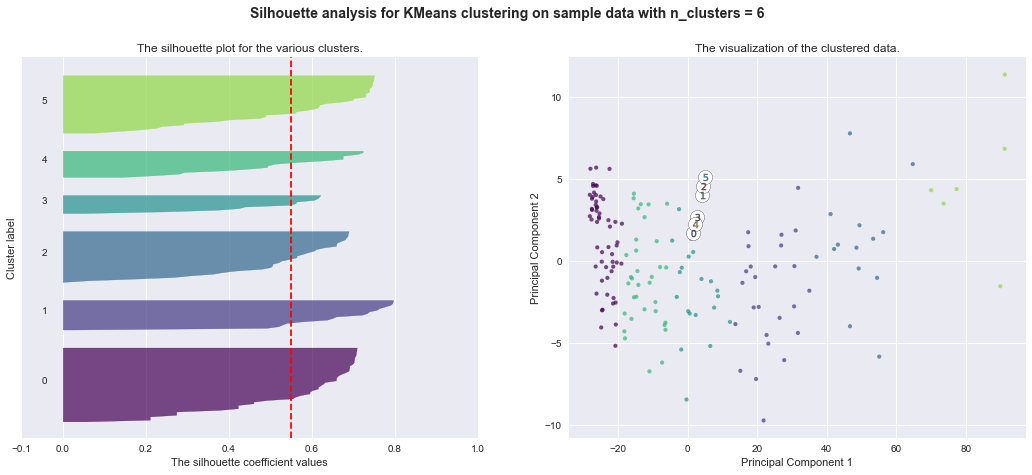

In [230]:
import matplotlib.cm as cm
%matplotlib inline

range_n_clusters = [3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(birthrate.values.reshape(-1, 1)) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(birthrate.values.reshape(-1, 1))

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(birthrate.values.reshape(-1, 1), cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(birthrate.values.reshape(-1, 1), cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.get_cmap('viridis')(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    
    clusterer2 = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels2 = clusterer.fit_predict(ndfeatures)
    kmeansndfeatures = pd.DataFrame(ndfeatures)
    kmeansndfeatures['cluster'] = cluster_labels2
    
    pca = PCA(n_components = 2)
    pca.fit(ndfeatures)
    pcafeatures = pca.transform(ndfeatures)
    
    # Label to color dict (automatic)
    label_color_dict = {label:idx for idx,label in enumerate(np.unique(kmeansndfeatures['cluster']))}

    # Color vector creation
    cvec = [label_color_dict[label] for label in kmeansndfeatures['cluster']]
    
    colors = cm.get_cmap('viridis')(cluster_labels2.astype(float) / n_clusters)
    ax2.scatter(pcafeatures[:, 0], pcafeatures[:, 1], marker = '.', s=70, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[0], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

As can be seen from the silhouette analysis, 3 clusters is best, with a general negative correlation between number of clusters and silhouette score, however 2 clusters would prove too simplistic and would miss detail. It is likely that this is the case because only one dimension is being analysed, and therefore a perfect silhouette score could be attained by having just one cluster, which is being reflected in the k-means algorithms fitting ability.

## Chloropleth Mapping

In [231]:
# setting up the world map to which the data will be applied and plotted

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
mapp = world = world[(world.pop_est>0) & (world.name!="Antarctica")] # removing antarctica for a cleaner image

In [232]:
mapp.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [233]:
# string matching the mapp gdf to match the country names of the other dfs being appended for clustering

mapp['name'] = mapp['name'].apply(lambda x: x.replace(' of America', '').strip())
mapp['name'] = mapp['name'].apply(lambda x: x.replace('Dem. Rep. Congo', 'Congo, Rep.').strip())
mapp['name'] = mapp['name'].apply(lambda x: x.replace('Laos', 'Lao').strip())
mapp['name'] = mapp['name'].apply(lambda x: x.replace('eSwatini', 'Eswatini').strip())
mapp['name'] = mapp['name'].apply(lambda x: x.replace('Dominican Rep.', 'Dominican Republic').strip())
mapp['name'] = mapp['name'].apply(lambda x: x.replace("Côte d'Ivoire", "Cote d'Ivoire").strip())
mapp['name'] = mapp['name'].apply(lambda x: x.replace('Central African Rep.', 'Central African Republic').strip())
mapp['name'] = mapp['name'].apply(lambda x: x.replace('Kyrgyzstan', 'Kyrgyz Republic').strip())
mapp['name'] = mapp['name'].apply(lambda x: x.replace('Solomon Is.', 'Solomon Islands').strip())
mapp['name'] = mapp['name'].apply(lambda x: x.replace('Slovakia', 'Slovak Republic').strip())
mapp['name'] = mapp['name'].apply(lambda x: x.replace('Czechia', 'Czech Republic').strip())
mapp['name'] = mapp['name'].apply(lambda x: x.replace('Bosnia and Herz.', 'Bosnia and Herzegovina').strip())

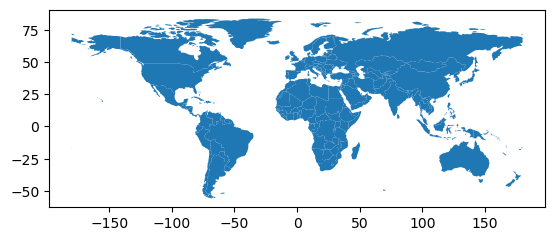

In [234]:
plt.style.use('default')
mapp.plot()

# renaming the 'name' column to country in order to facilitate merging with the data sets on this column

mapp.rename(columns = {'name': 'country'}, inplace = True) 

In [235]:
# creating a dataframe to view the countries in the map shape file that there is no data for
# these were purposely kept in the pre-pricessing stage by performing a 'left/right' join with the map file

df1 = birthrateclustering[birthrateclustering.isna().any(axis=1)]

print(df1)

# adding the indexes of these instances to a list

indexes = df1.index.tolist()

                      country  birth rate  year   pop_est  \
602                 W. Sahara         NaN   NaN    603253   
5720             Falkland Is.         NaN   NaN      2931   
6022                Greenland         NaN   NaN     57713   
6023   Fr. S. Antarctic Lands         NaN   NaN       140   
12345             Puerto Rico         NaN   NaN   3351827   
18667                   Congo         NaN   NaN   4954674   
18969              Eq. Guinea         NaN   NaN    778358   
38234           New Caledonia         NaN   NaN    279070   
39740                  Taiwan         NaN   NaN  23508428   
45159               N. Cyprus         NaN   NaN    265100   
46966              Somaliland         NaN   NaN   3500000   
47870               Macedonia         NaN   NaN   2103721   
48473                  Kosovo         NaN   NaN   1895250   
48775                S. Sudan         NaN   NaN  13026129   

                     continent iso_a3  gdp_md_est  \
602                     Africa 

In [236]:
# isolating the most up to date complete year of the data (2018), and the babies per woman (named birth rate) column

mappingdf = birthrateclustering.loc[birthrateclustering.year == 2018]
birthrate = mappingdf['birth rate']

# implementing the k-means clustering algorithm with the previously discovered optimum value for number of clusters

kmeans = KMeans(n_clusters = 3)
clusters = kmeans.fit_predict(birthrate.values.reshape(-1, 1))

In [237]:
# creating a separate dataframe made up of the previously initialised indexes of rows that contain countries present
# in the map shape file for which we have no data

appendingdf = birthrateclustering.iloc[indexes, :]

In [238]:
# creating a new column for both: clusters, making them NaN. Now, we at least have a NaN value for the countries
# we do not have data for, which can be addressed with a colouring or legend in the chloropleth map, as opposed to being
# left out, making the map look incomplete.

mappingdf['cluster'] = clusters
appendingdf['cluster'] = np.nan

<ipython-input-238-ae8472604f5c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mappingdf['cluster'] = clusters
<ipython-input-238-ae8472604f5c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appendingdf['cluster'] = np.nan


In [239]:
# concatenating the two dataframes

frames = [mappingdf, appendingdf]
df = pd.concat(frames)

In [240]:
# isolating the only columns we need for merging and mapping

df = df[['country', 'continent', 'cluster']]

In [241]:
# convering to a geodataframe, in order to merge with another

gdf = gpd.GeoDataFrame(df)

In [242]:
# merging with the map shape file

mapp = pd.merge(mapp, gdf, how = 'left', on = ['country', 'continent'])

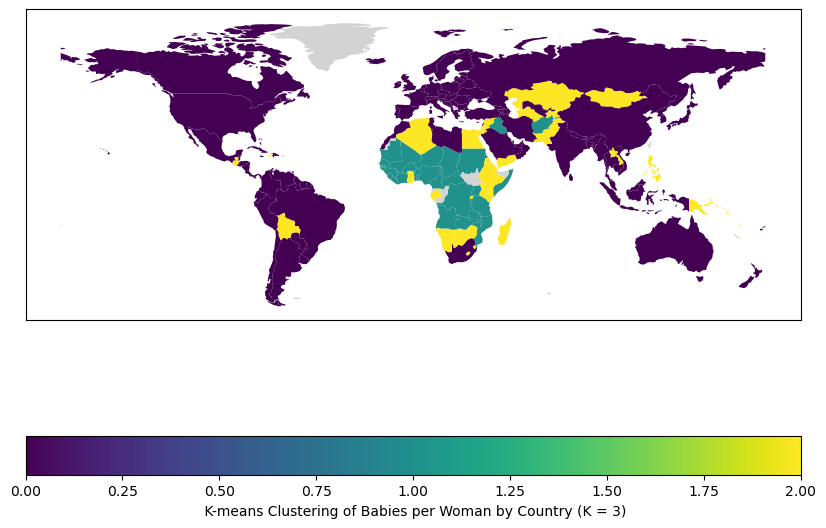

In [243]:
# creating the first chloropleth map, colouring by the clusters created with babies per woman

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize = (10, 10))


mapp.plot(column = 'cluster', missing_kwds={'color': 'lightgrey', "label": "Missing values"}, ax = ax,\
        legend = True, legend_kwds={'label': " K-means Clustering of Babies per Woman by Country (K = 3)", 'orientation': "horizontal"})
ax.set_xticks([])
ax.set_yticks([]);

In [282]:
# repeating for HDI

# isolating HDI for 2018
mappingdf = hdi.loc[hdi.year == 2018]
hdiclustering = mappingdf['hdi']

# clustering
kmeans = KMeans(n_clusters = 3)
clusters = kmeans.fit_predict(hdiclustering.values.reshape(-1, 1))

In [283]:
# creating dataframe with any rows that do not have data
df1 = mappingdf[mappingdf.isna().any(axis=1)]
print(df1)
indexes = df1.index.tolist()
print(mappingdf.shape)

appendingdf = mappingdf.iloc[indexes, :]
mappingdf['hdicluster'] = clusters
appendingdf['hdicluster'] = np.nan


Empty DataFrame
Columns: [country, hdi, year, pop_est, continent, iso_a3, gdp_md_est, geometry]
Index: []
(160, 8)


<ipython-input-283-5575e5e330d2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mappingdf['hdicluster'] = clusters


There were no missing values for HDI in 2018, so no dataframe needs to be concatenated to get NaN values for the countries not featured in the data.

In [284]:
df = mappingdf.copy()
print(df.shape)
print(df.hdicluster.value_counts())
df1 = df[df.isna().any(axis=1)]
display(df1)

(160, 9)
2    57
0    53
1    50
Name: hdicluster, dtype: int64


Empty DataFrame
Columns: [country, hdi, year, pop_est, continent, iso_a3, gdp_md_est, geometry, hdicluster]
Index: []

In [287]:
# merging with the geodataframe (i couldn't put my finger on why but the map below was running an error every other
# time i ran this cell, so, to remedy that i just repeated the 3 lines of code it contained. must have something to do
# with the left join, meaning that the mapp variable does not contain hdicluster column every other time.)

df = df[['country', 'continent', 'hdicluster']]
gdf = gpd.GeoDataFrame(df)
mapp = pd.merge(mapp, gdf, how = 'left', on = ['country', 'continent'])

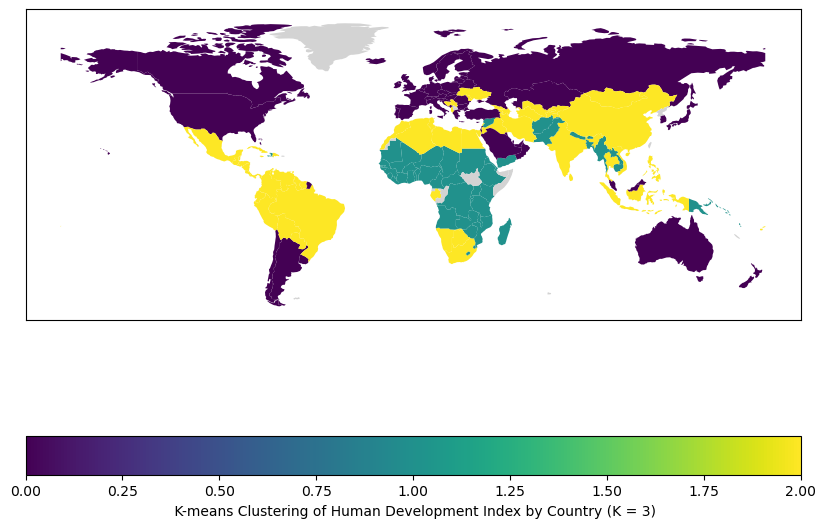

In [288]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, figsize = (10, 10))


mapp.plot(column = 'hdicluster', missing_kwds={'color': 'lightgrey', "label": "Missing values"}, ax = ax,\
        legend = True, legend_kwds={'label': " K-means Clustering of Human Development Index by Country (K = 3)", 'orientation': "horizontal"})
ax.set_xticks([])
ax.set_yticks([]);

## PCA

In [311]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [312]:
df = pd.read_csv('all_merged_data.csv')
hdi = pd.read_csv('hdi_clustering.csv', index_col = 0)
df = df.loc[df.year >=1900]
df = pd.merge(df, hdi, how = 'inner', on = ['country', 'year'])

In [304]:
# working with the ndfeatures variable made earlier, as it contains no NaN values, and is significantly smaller as it
# only uses 2018's data, which also contains every feature.

ndfeatures.head()

birth rate  child mortality  gdp_per_capita  life expectancy    hdi
28         4.33            62.30           3.380             63.7  0.496
57         1.71             8.82           5.230             78.3  0.791
86         2.64            23.50           2.680             77.9  0.759
115        5.55            77.20           3.550             64.6  0.574
144        2.26             9.94           0.861             76.8  0.830

In [305]:
# getting rid of the cluster column

ndfeatures = ndfeatures.iloc[:, 0:5]

In [306]:
# scaling the features to be used in preparation for PCA 

ndfeatures = preprocessing.scale(ndfeatures)

In [307]:
# applying principal component analysis

pca = PCA(n_components = 2)
pca.fit(ndfeatures)

PCA(n_components=2)

In [308]:
# Look at the component loadings

print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[3.68371103 0.91947227]
[0.7320195  0.18271564]


It would appear that the first principal component captures almost 73% of the variance, quite a lot for one feature. The second PC is also significant, bringing total variance captured to around 95%.

                        0         1
hdi              0.501052  0.036265
child mortality  0.498620  0.080962
life expectancy  0.488653  0.083760
birth rate       0.476907  0.170067
gdp_per_capita   0.184666  0.977850


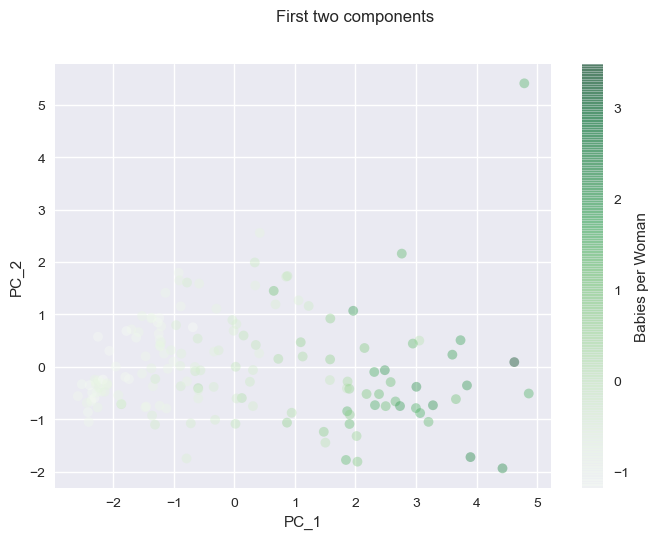

In [309]:
# project the features into these principle components
projectedAxes = pca.transform(ndfeatures)

plt.figure(1)
plt.suptitle('First two components')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.scatter(projectedAxes[:,0], projectedAxes[:,1], c = ndfeatures[:, 0], cmap = plt.cm.Greens, s = 50, alpha = 0.4, linewidth=0)
plt.colorbar().set_label('Babies per Woman');

loadings=pd.DataFrame(pca.components_,columns=df[['birth rate', 'child mortality', 'gdp_per_capita', 'life expectancy', 'hdi']].columns.values)
loadings=loadings.transpose()
loadings=loadings.abs()
loadings=loadings.sort_values(by =0,ascending=False)
print(loadings)

It would seem that the first principal component, constituted broadly of birth rate, life expectancy, and child mortality, is highly correlated, and the main role of the second PC is to capture the high variance in gdp per capita, which, due to some outliers, appears to have some high variance.

The first principle component seems to broadly distinguish countries with high birth rates, so the loadings on the first component are likely to be discriminating of this.

## Relationships between variables further explored

In [49]:
display(df.head())
df.shape

Unnamed: 0      country  birth rate  year  child mortality  gdp_per_capita  \
0         190  Afghanistan        7.47  1990            179.0          -0.572   
1         191  Afghanistan        7.48  1991            173.0          -7.950   
2         192  Afghanistan        7.50  1992            167.0         -13.900   
3         193  Afghanistan        7.54  1993            161.0         -10.400   
4         194  Afghanistan        7.57  1994            156.0          20.300   

   life expectancy  population continent_x    hdi   pop_est continent_y  \
0             52.6    12400000        Asia  0.298  34124811        Asia   
1             52.4    13300000        Asia  0.304  34124811        Asia   
2             52.9    14500000        Asia  0.312  34124811        Asia   
3             53.1    15800000        Asia  0.308  34124811        Asia   
4             52.7    17100000        Asia  0.303  34124811        Asia   

  iso_a3  gdp_md_est                                           geometry  \
0    AFG     64080.0  POLYGON ((66.51860680528867 37.36278432875879,...   
1    AFG     64080.0  POLYGON ((66.51860680528867 37.36278432875879,...   
2    AFG     64080.0  POLYGON ((66.51860680528867 37.36278432875879,...   
3    AFG     64080.0  POLYGON ((66.51860680528867 37.36278432875879,...   
4    AFG     64080.0  POLYGON ((66.51860680528867 37.36278432875879,...   

   population m  
0          12.4  
1          13.3  
2          14.5  
3          15.8  
4          17.1

(4613, 16)

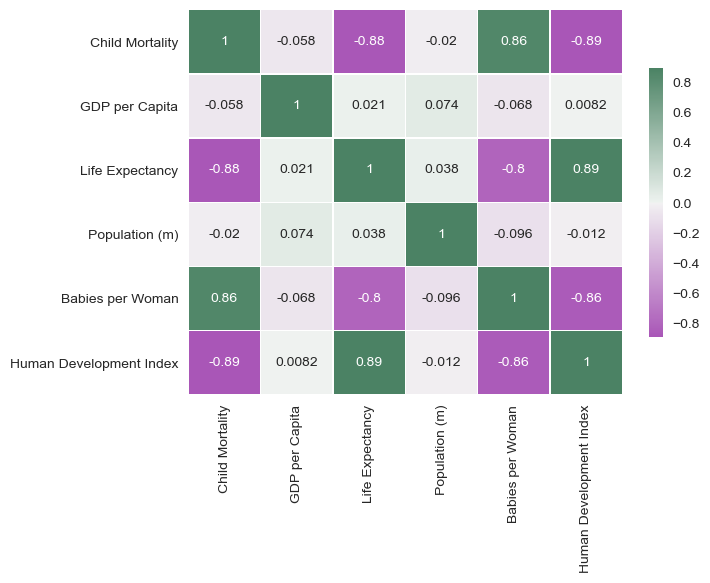

In [50]:
features = df[['child mortality', 'gdp_per_capita', 'life expectancy', 'population', 'birth rate', 'hdi']]
ticklabels = ['Child Mortality', 'GDP per Capita', 'Life Expectancy', 'Population (m)', 'Babies per Woman',\
             'Human Development Index']
corrs = features.corr()

cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True).reversed()
fig, ax = plt.subplots(figsize=(7,5))   
sns.heatmap(corrs, cmap = cmap, vmax=.9, cbar_kws={'shrink':.7}, linewidths=.3, annot = True, ax = ax,\
           xticklabels = ticklabels, yticklabels = ticklabels);
plt.yticks(rotation = 0)

plt.show();

While it is thought to be unlikely that gdp per capita has so little to do with HDI, the data here is not well correlated, and the PCA analysis saw the same thing, with the second principal component being dedicated almost entirely to capturing the variance in gdp per capita. Therefore, this variable, as well as population, which has almmost as little association with HDI, will not be included in the modelling stage. In fact, with Babies per Woman being the desired main indicator on which the model is built, it could be most suitable to only include this as a single feature predictor, given that the other variables tend to be highly correlated with babies per woman as well, introducing collinearity problems. This makes sense, given that child mortality and life expectancy could be argued to be speaking to the same essence of information as babies per woman, at least with ample overlap in meaning. This would constitute the state of the art aspect of the present research, given that it would champion babies per woman as a predictor of level of development of a country, given the myriad knock-on effects that women's ability to choose their reproductive destiny has on a society.

To be sure however, 2 models will be built: one the aforementioned single variable linear regression with babies per woman, as well as a multiple regression which will carry through all of the above variables, save for gdp per capita and population, which could prove confounding on results. This is just to check there is no stark difference in results, although the multiple is expected to perform slightly better of course.

## EDA for modelling data set with all features

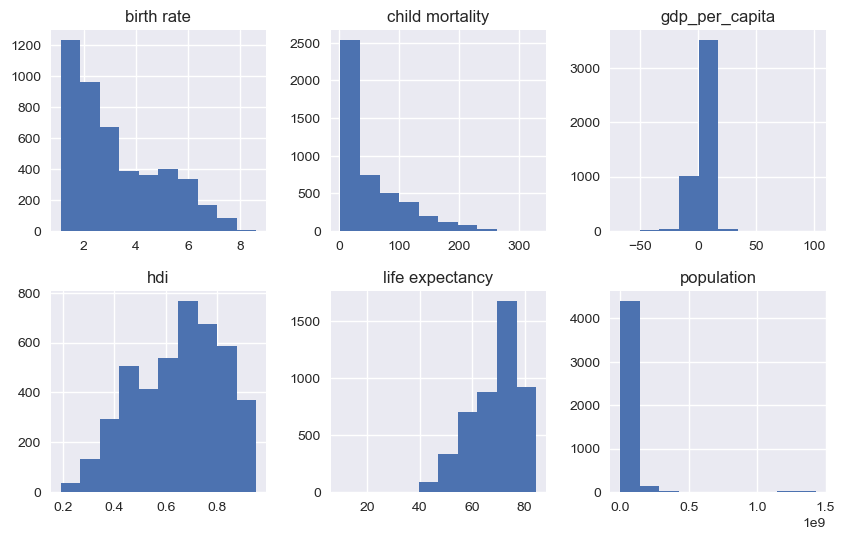

In [313]:
plt.style.use('seaborn')

# credit for histogram loop code to author of PoDS lab 2 feedback


numdf = df[['birth rate', 'child mortality', 'gdp_per_capita', 'hdi', 'life expectancy', 'population']]

numCols=numdf.shape[1]


fig, axisRows = plt.subplots(numCols//5+1, 3, figsize=(10, 6))
i = 0
for axisCols in axisRows:
    for axis in axisCols:
        if (i<numCols):
            numdf.hist(column = numdf.columns[i], bins = 10, ax=axis)
            i = i+1

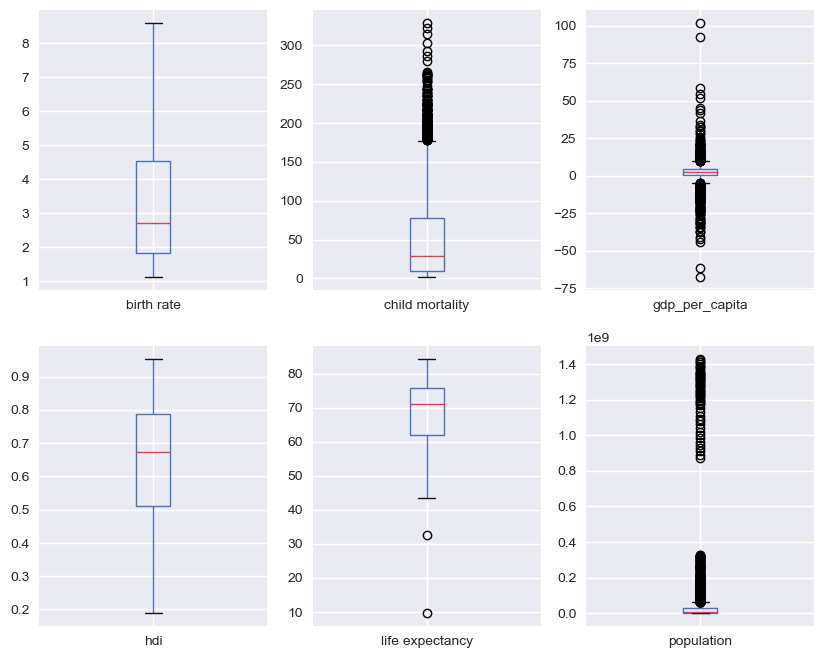

In [314]:
fig, axisRows = plt.subplots(numCols//6+1, 3, figsize=(10, 8))
i = 0
for axisCols in axisRows:
    for axis in axisCols:
        if (i<numCols):
            numdf.boxplot(column = numdf.columns[i], ax=axis, vert = True)
            
            i = i+1

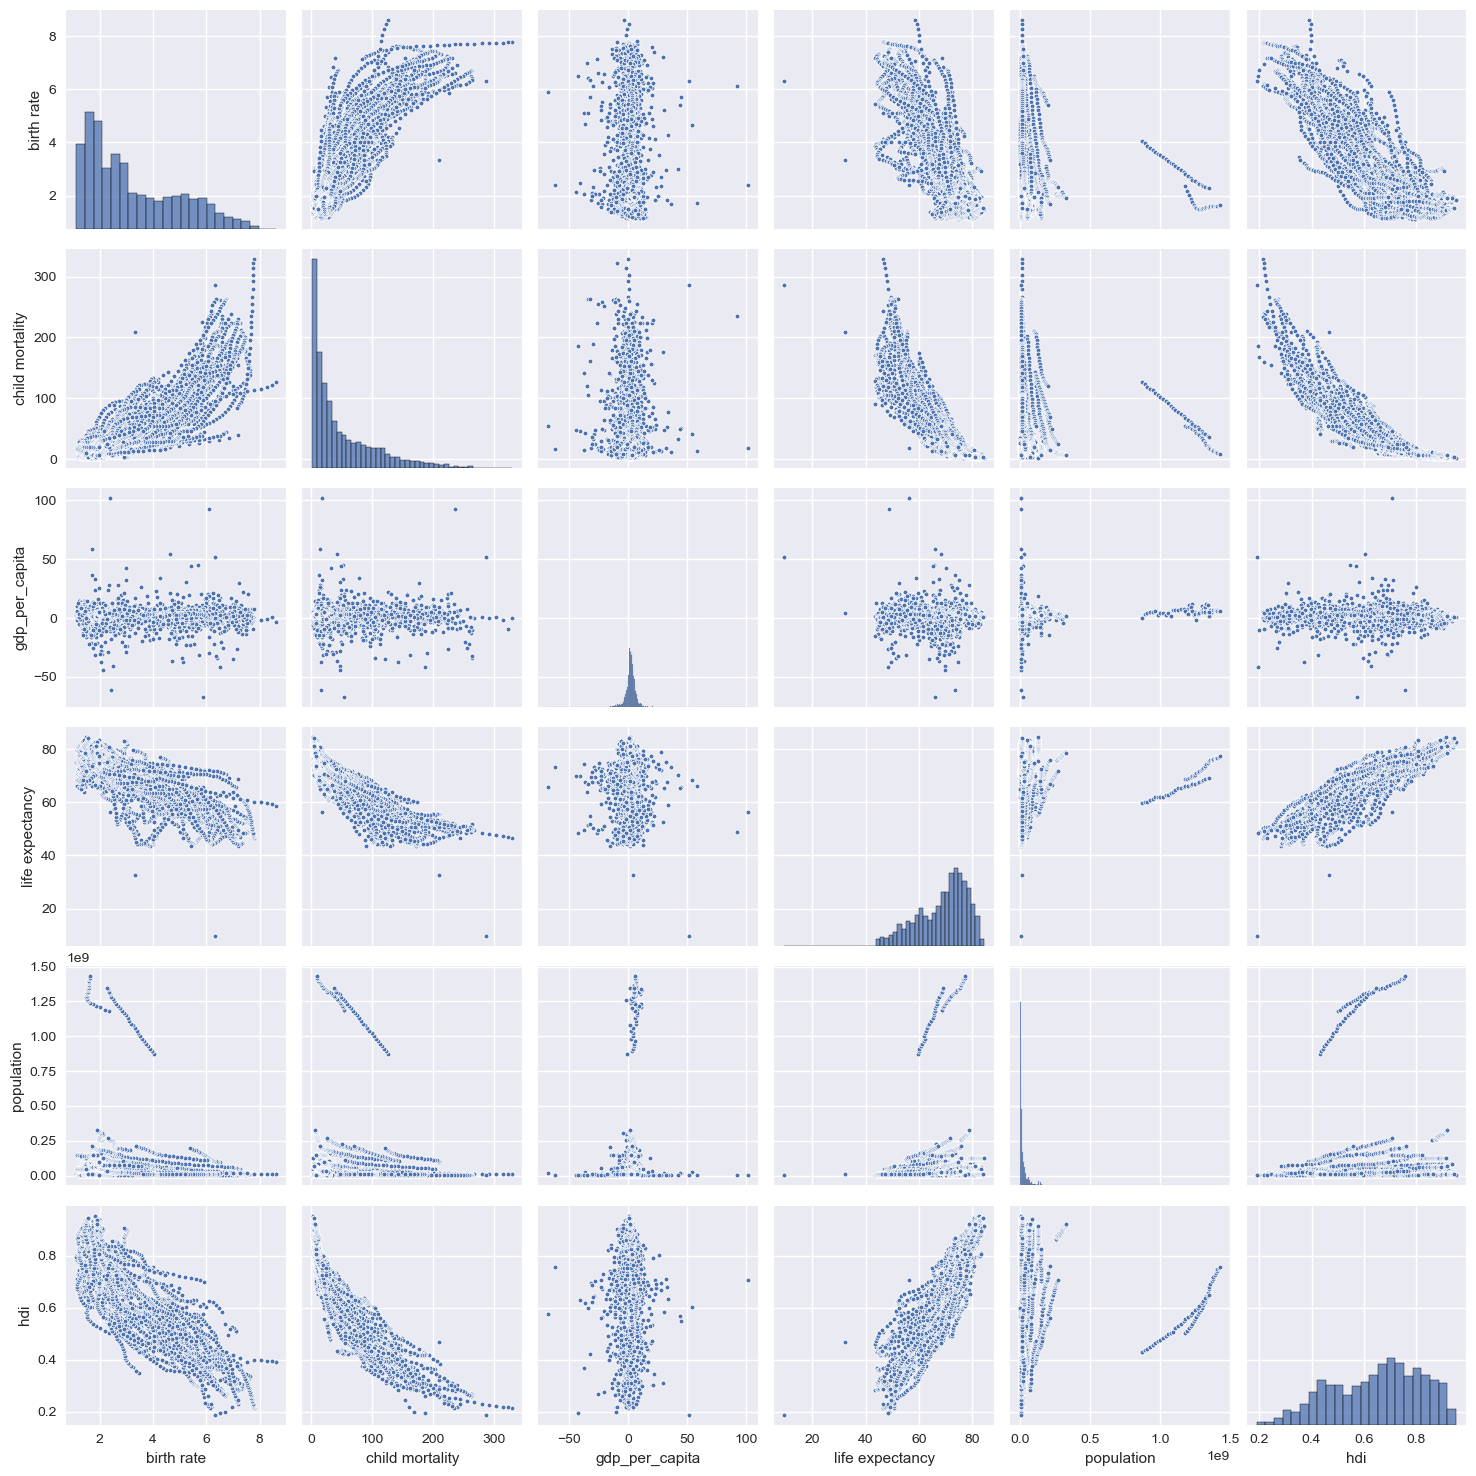

In [214]:
# attempting making nicer images

pairplot = sns.pairplot(df[['birth rate', 'child mortality', 'gdp_per_capita', 'life expectancy', 'population', 'hdi']],\
            kind = 'scatter', diag_kind = 'hist', markers = '.');

In [215]:
# creating the more manageable population metric, which would not overpower any model

df['population m'] = df['population']/1000000

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

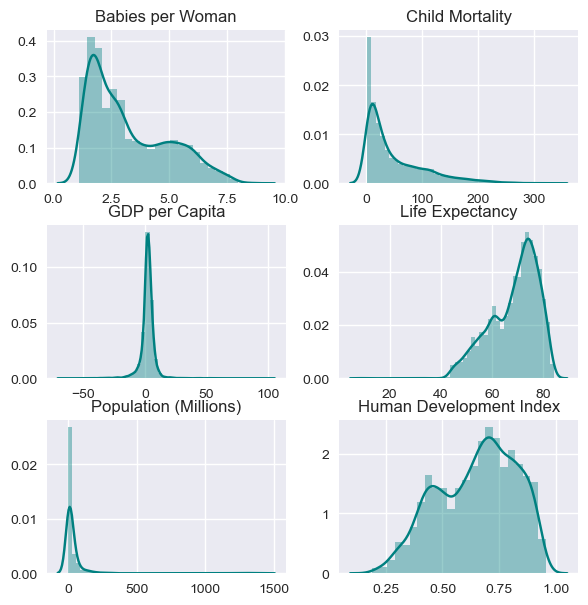

In [216]:
# plotting histograms for each of the variables

f, axes = plt.subplots(3, 2, figsize=(6, 6))
f.subplots_adjust(wspace = 1.5, hspace = 0)
f.tight_layout()
sns.distplot(df['birth rate'], ax = axes[0,0], color = 'teal')
axes[0, 0].set(ylabel = None, xlabel = None, title = 'Babies per Woman')
sns.distplot(df['child mortality'], ax = axes[0,1], color = 'teal')
axes[0, 1].set(ylabel = None, xlabel = None, title = 'Child Mortality')
sns.distplot(df['gdp_per_capita'], ax = axes[1,0], color = 'teal')
axes[1, 0].set(ylabel = None, xlabel = None, title = 'GDP per Capita')
sns.distplot(df['life expectancy'], ax = axes[1,1], color = 'teal')
axes[1, 1].set(ylabel = None, xlabel = None, title = 'Life Expectancy')
sns.distplot(df['population m'], ax = axes[2,0], color = 'teal')
axes[2, 0].set(ylabel = None, xlabel = None, title = 'Population (Millions)')
sns.distplot(df['hdi'], ax = axes[2,1], color = 'teal')
axes[2, 1].set(ylabel = None, xlabel = None, title = 'Human Development Index');

In [51]:
logdf = df.copy()

logdf['birth rate (log)'] = logdf['birth rate'].apply(lambda x: np.log(x) if x != 0 else x)
logdf['child mortality (log)'] = logdf['child mortality'].apply(lambda x: np.log(x) if x != 0 else x)

logdf = logdf[['birth rate (log)', 'child mortality (log)', 'life expectancy', 'hdi']]

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Applications/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

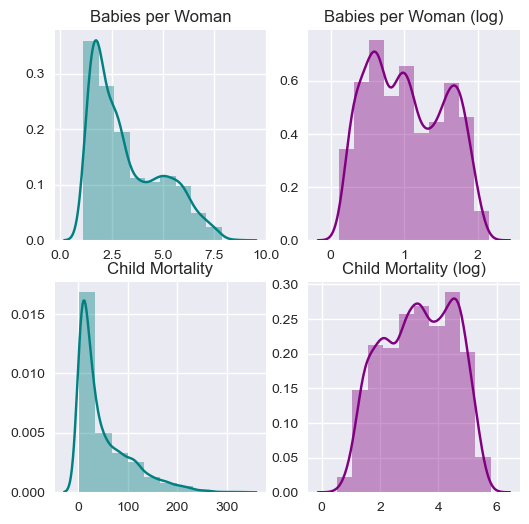

In [52]:
f, axes = plt.subplots(2, 2, figsize=(6, 6))

sns.distplot(logdf['birth rate (log)'], bins = 10, ax = axes[0, 1], color = 'purple')
axes[0, 1].set(ylabel = None, xlabel = None, title = 'Babies per Woman (log)')
sns.distplot(logdf['child mortality (log)'], bins = 10, ax = axes[1, 1], color = 'purple')
axes[1, 1].set(ylabel = None, xlabel = None, title = 'Child Mortality (log)')
sns.distplot(df['birth rate'], bins = 10, ax = axes[0, 0], color = 'teal')
axes[0, 0].set(ylabel = None, xlabel = None, title = 'Babies per Woman')
sns.distplot(df['child mortality'], bins = 10, ax = axes[1, 0], color = 'teal')
axes[1, 0].set(ylabel = None, xlabel = None, title = 'Child Mortality')


plt.show()


## Modelling

In [53]:
logdf = logdf[['birth rate (log)', 'child mortality (log)', 'life expectancy']]
toMerge = df[['life expectancy', 'hdi']]

mr = pd.merge(logdf, toMerge, how ='inner', on = 'life expectancy')

In [54]:
mr.shape

(77945, 4)

In [55]:
df1 = mr[mr.isna().any(axis=1)]
df1
toDrop = df1.index.tolist()

In [56]:
mr.drop(toDrop, inplace = True)

In [57]:
mr

birth rate (log)  child mortality (log)  life expectancy    hdi
0              2.010895               5.187386             52.6  0.298
1              2.010895               5.187386             52.6  0.310
2              2.010895               5.187386             52.6  0.524
3              2.010895               5.187386             52.6  0.493
5              2.010895               5.187386             52.6  0.542
...                 ...                    ...              ...    ...
77940          1.806648               5.153292             45.5  0.420
77941          1.806648               5.153292             45.5  0.419
77942          1.391282               4.644391             46.2  0.453
77943          1.386294               4.605170             45.9  0.434
77944          1.388791               4.574711             46.3  0.432

[73942 rows x 4 columns]

In [58]:
r = mr[['birth rate (log)', 'hdi']]

In [59]:
# scaling the two dataframes in preparation of modelling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

mrscaler = StandardScaler().fit(mr)
scaler = StandardScaler().fit(r)

mr = mrscaler.transform(mr)
r = scaler.transform(r)

In [60]:
mr

array([[ 2.40873526,  2.12150826, -2.76369634, -2.75390851],
       [ 2.40873526,  2.12150826, -2.76369634, -2.66953829],
       [ 2.40873526,  2.12150826, -2.76369634, -1.16493597],
       ...,
       [ 1.05665747,  1.59205902, -3.68874654, -1.66412646],
       [ 1.04577399,  1.55381672, -3.73210827, -1.79771264],
       [ 1.05122251,  1.52411735, -3.67429263, -1.81177435]])

In [61]:
r

array([[ 2.40873526, -2.75390851],
       [ 2.40873526, -2.66953829],
       [ 2.40873526, -1.16493597],
       ...,
       [ 1.05665747, -1.66412646],
       [ 1.04577399, -1.79771264],
       [ 1.05122251, -1.81177435]])

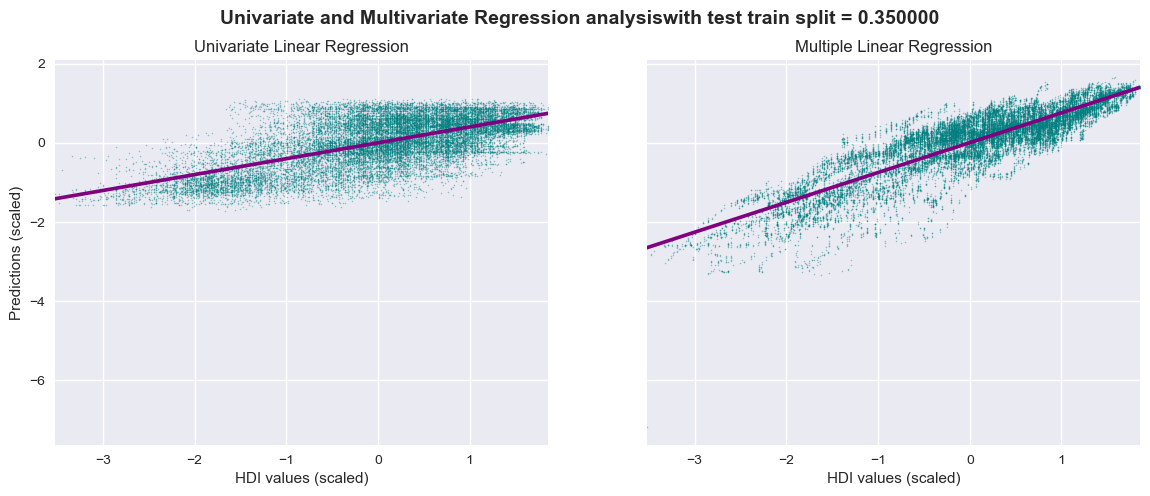

for test size =  0.35
Univariate regression R2:  0.40413798447811033
univariate regression mean squared error:  0.5976767878775567
multivariate regression R2:  0.7535274426373271
multivariate regression mean squared error:  0.2474223622031161


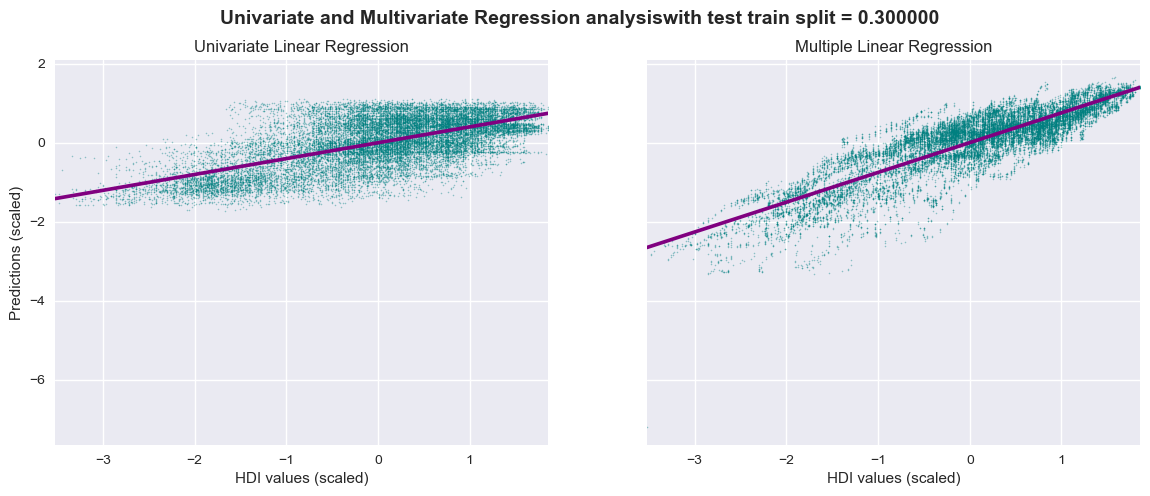

for test size =  0.3
Univariate regression R2:  0.40413798447811033
univariate regression mean squared error:  0.5976767878775567
multivariate regression R2:  0.7518171190518451
multivariate regression mean squared error:  0.24893875297852763


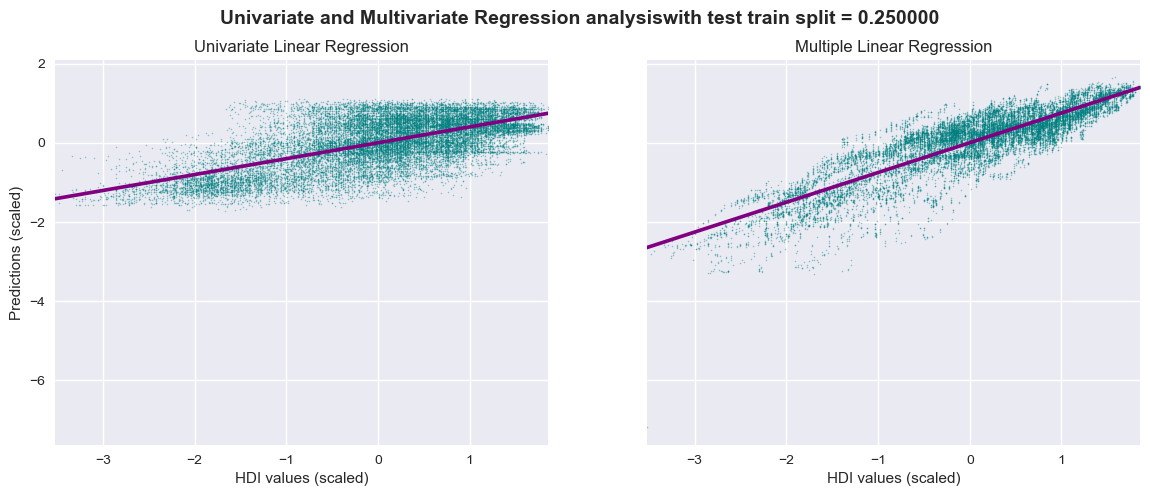

for test size =  0.25
Univariate regression R2:  0.40413798447811033
univariate regression mean squared error:  0.5976767878775567
multivariate regression R2:  0.752129913871828
multivariate regression mean squared error:  0.24835632435721156


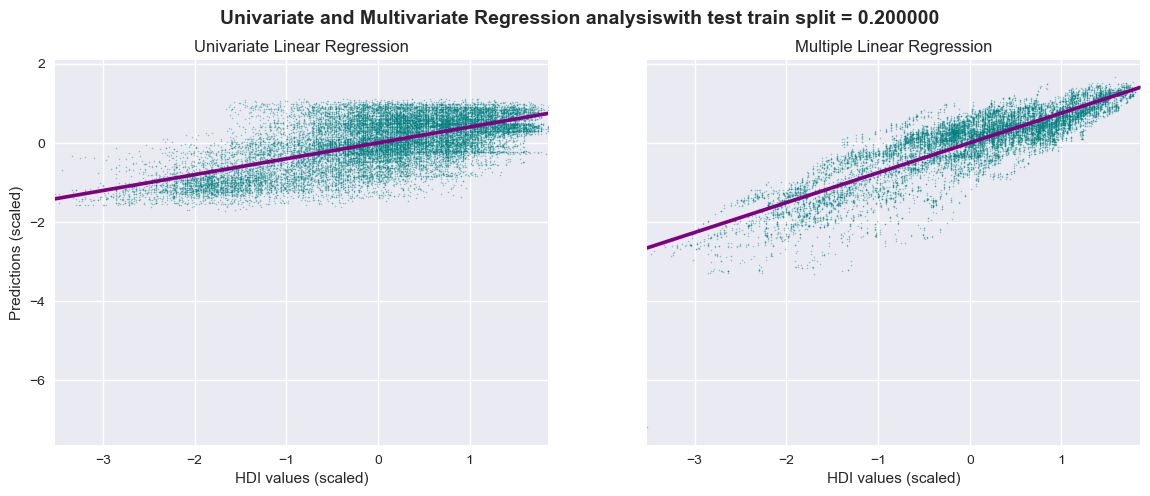

for test size =  0.2
Univariate regression R2:  0.40413798447811033
univariate regression mean squared error:  0.5976767878775567
multivariate regression R2:  0.750465763529505
multivariate regression mean squared error:  0.25018869439177077


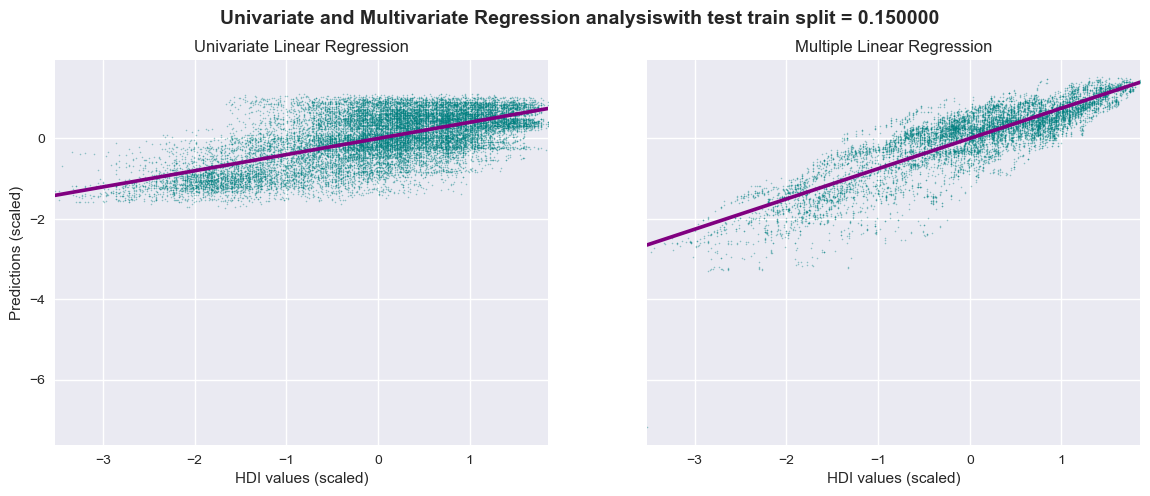

for test size =  0.15
Univariate regression R2:  0.40413798447811033
univariate regression mean squared error:  0.5976767878775567
multivariate regression R2:  0.7509964104318562
multivariate regression mean squared error:  0.25198247964573994


In [62]:
# test train split for both dataframes
test_sizes = [0.35, 0.3, 0.25, 0.2, 0.15]

for each in test_sizes:
    mrxtrain, mrxtest, mrytrain, mrytest = train_test_split(mr[:, 0:3], mr[:, -1], test_size=each, random_state=10)
    xtrain, xtest, ytrain, ytest = train_test_split(r[:, 0], r[:, 1], test_size = 0.3, random_state = 10)
    
    # initializing and fitting models

    lr = LinearRegression()
    mlr = LinearRegression()
    lr.fit(xtrain.reshape(-1, 1), ytrain.reshape(-1, 1))
    mlr.fit(mrxtrain, mrytrain.reshape(-1, 1))
    
    # Make predictions using the testing set

    lrpreds = lr.predict(xtest.reshape(-1, 1))
    mrpreds = mlr.predict(mrxtest)

    f, axes = plt.subplots(1, 2, figsize = (14, 5), sharey = True)
    sns.regplot(x = ytest, y = lrpreds, color = 'purple', marker = '.', scatter_kws={'s':5, 'alpha': 0.4, 'color':"teal"},\
               ax = axes[0])
    axes[0].set(ylabel = 'Predictions (scaled)', title = 'Univariate Linear Regression', xlabel = 'HDI values (scaled)')
    sns.regplot(x = mrytest, y = mrpreds, color = 'purple', marker = '.', scatter_kws={'s':5, 'alpha': 0.4, 'color':"teal"},\
               ax = axes[1])
    axes[1].set(title = 'Multiple Linear Regression', xlabel = 'HDI values (scaled)')
    
    plt.suptitle(("Univariate and Multivariate Regression analysis"
                  "with test train split = %f" % each),
                 fontsize=14, fontweight='bold')
    
    plt.show()
    # evaluating performance

    from sklearn.metrics import r2_score as r2
    from sklearn.metrics import mean_squared_error as mse
    
    print('for test size = ', str(each))
    print('Univariate regression R2: ', r2(ytest, lrpreds))
    print('univariate regression mean squared error: ', mse(ytest, lrpreds))
    print('multivariate regression R2: ', r2(mrytest, mrpreds))
    print('multivariate regression mean squared error: ', mse(mrytest, mrpreds))

[Text(0.5, 1.0, 'Multiple Linear Regression'),
 Text(0.5, 0, 'HDI values (scaled)')]

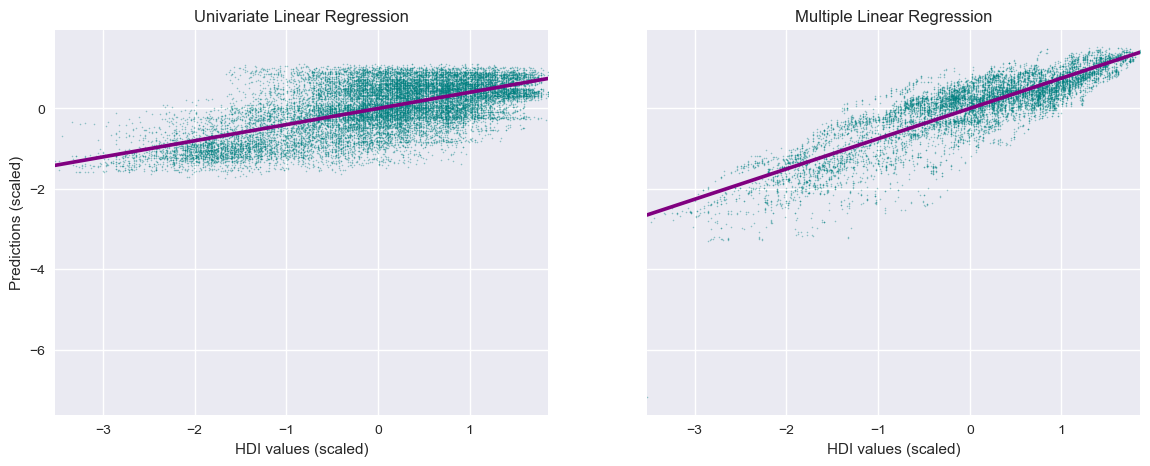

In [64]:
# Make predictions using the testing set

lrpreds = lr.predict(xtest.reshape(-1, 1))
mrpreds = mlr.predict(mrxtest)

f, axes = plt.subplots(1, 2, figsize = (14, 5), sharey = True)
sns.regplot(x = ytest, y = lrpreds, color = 'purple', marker = '.', truncate = True, scatter_kws={'s':5, 'alpha': 0.4, 'color':"teal"},\
           ax = axes[0])
axes[0].set(ylabel = 'Predictions (scaled)', title = 'Univariate Linear Regression', xlabel = 'HDI values (scaled)')
sns.regplot(x = mrytest, y = mrpreds, color = 'purple', marker = '.', truncate = True, scatter_kws={'s':5, 'alpha': 0.4, 'color':"teal"},\
           ax = axes[1])
axes[1].set(title = 'Multiple Linear Regression', xlabel = 'HDI values (scaled)')


In [65]:
# scaling the two dataframes in preparation of modelling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression

mrscaler = RobustScaler().fit(mr)
scaler = RobustScaler().fit(r)

mr = mrscaler.transform(mr)
r = scaler.transform(r)

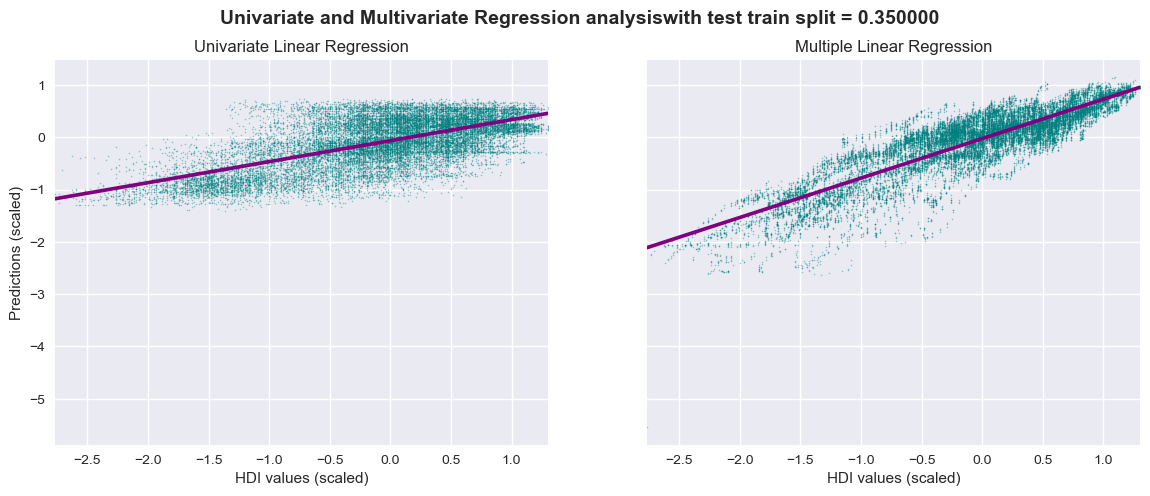

for test size =  0.35
Univariate regression R2:  0.4041379844781102
univariate regression mean squared error:  0.34208559245839304
multivariate regression R2:  0.7535274426373272
multivariate regression mean squared error:  0.1416143759945514


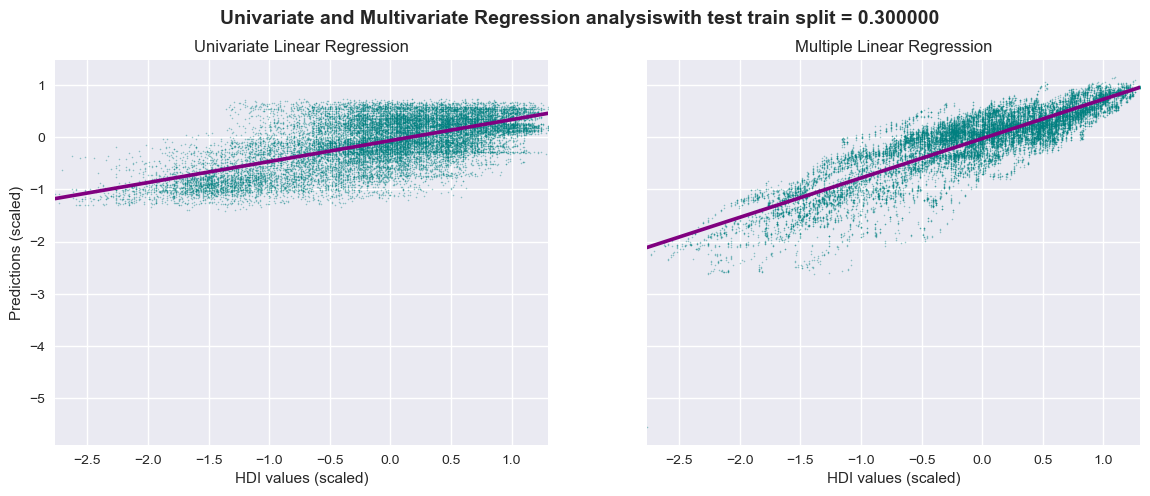

for test size =  0.3
Univariate regression R2:  0.4041379844781102
univariate regression mean squared error:  0.34208559245839304
multivariate regression R2:  0.751817119051845
multivariate regression mean squared error:  0.14248229565836706


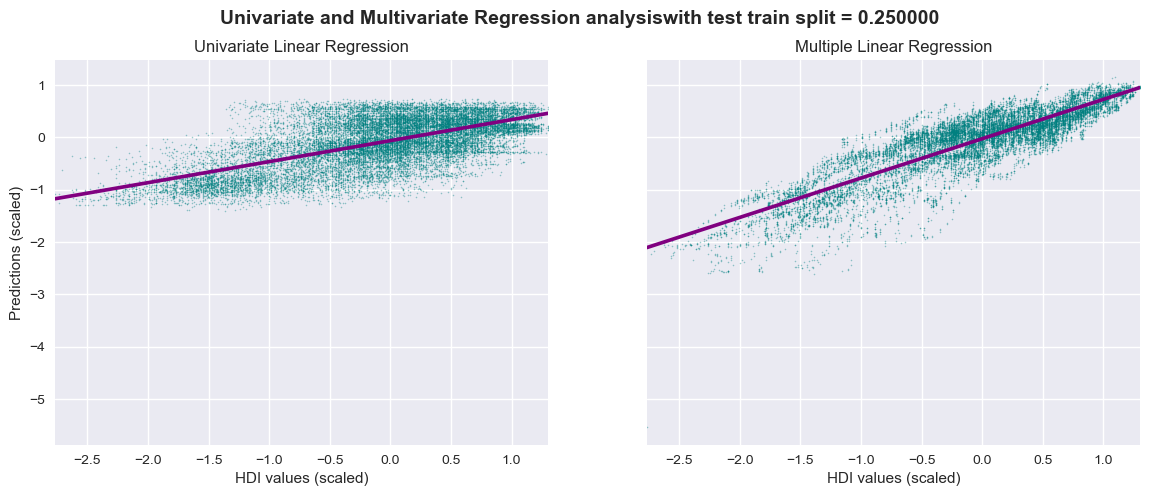

for test size =  0.25
Univariate regression R2:  0.4041379844781102
univariate regression mean squared error:  0.34208559245839304
multivariate regression R2:  0.752129913871828
multivariate regression mean squared error:  0.14214893748882


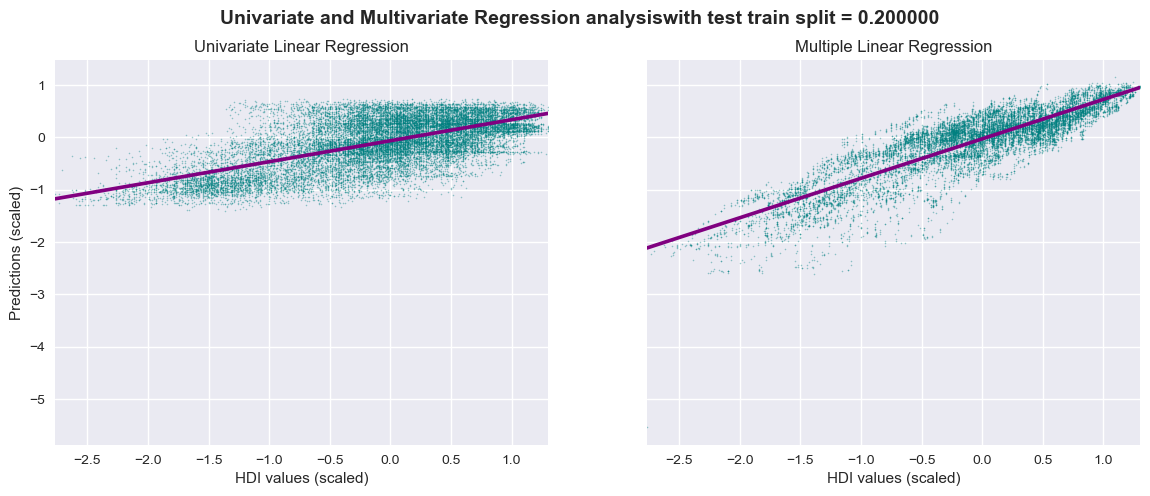

for test size =  0.2
Univariate regression R2:  0.4041379844781102
univariate regression mean squared error:  0.34208559245839304
multivariate regression R2:  0.750465763529505
multivariate regression mean squared error:  0.14319771067457673


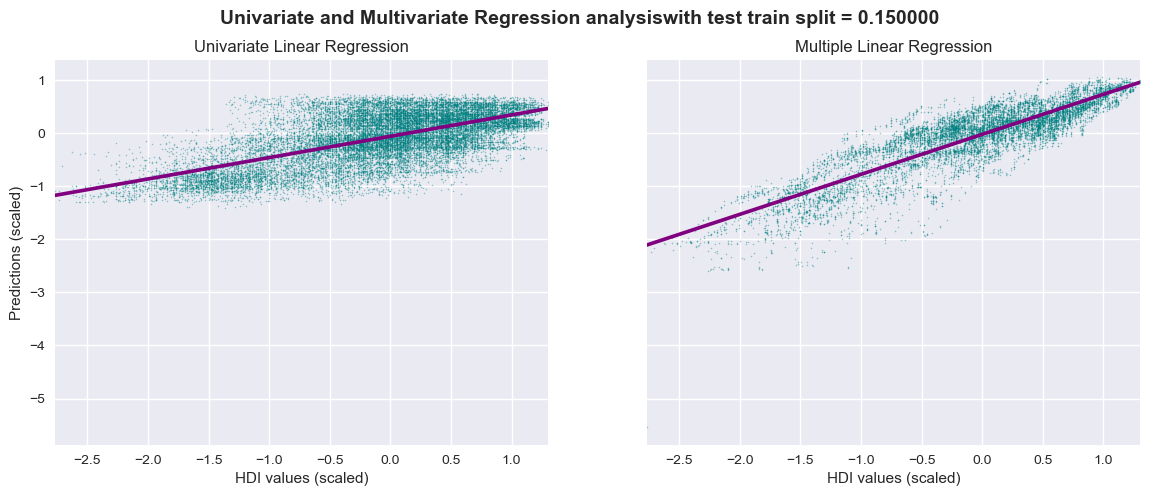

for test size =  0.15
Univariate regression R2:  0.4041379844781102
univariate regression mean squared error:  0.34208559245839304
multivariate regression R2:  0.750996410431856
multivariate regression mean squared error:  0.1442243995201086


In [66]:
# test train split for both dataframes
test_sizes = [0.35, 0.3, 0.25, 0.2, 0.15]

for each in test_sizes:
    mrxtrain, mrxtest, mrytrain, mrytest = train_test_split(mr[:, 0:3], mr[:, -1], test_size=each, random_state=10)
    xtrain, xtest, ytrain, ytest = train_test_split(r[:, 0], r[:, 1], test_size = 0.3, random_state = 10)
    
    # initializing and fitting models

    lr = LinearRegression()
    mlr = LinearRegression()
    lr.fit(xtrain.reshape(-1, 1), ytrain.reshape(-1, 1))
    mlr.fit(mrxtrain, mrytrain.reshape(-1, 1))
    
    # Make predictions using the testing set

    lrpreds = lr.predict(xtest.reshape(-1, 1))
    mrpreds = mlr.predict(mrxtest)

    f, axes = plt.subplots(1, 2, figsize = (14, 5), sharey = True)
    sns.regplot(x = ytest, y = lrpreds, color = 'purple', marker = '.', scatter_kws={'s':5, 'alpha': 0.4, 'color':"teal"},\
               ax = axes[0])
    axes[0].set(ylabel = 'Predictions (scaled)', title = 'Univariate Linear Regression', xlabel = 'HDI values (scaled)')
    sns.regplot(x = mrytest, y = mrpreds, color = 'purple', marker = '.', scatter_kws={'s':5, 'alpha': 0.4, 'color':"teal"},\
               ax = axes[1])
    axes[1].set(title = 'Multiple Linear Regression', xlabel = 'HDI values (scaled)')
    
    plt.suptitle(("Univariate and Multivariate Regression analysis"
                  "with test train split = %f" % each),
                 fontsize=14, fontweight='bold')
    
    plt.show()
    # evaluating performance

    from sklearn.metrics import r2_score as r2
    from sklearn.metrics import mean_squared_error as mse
    
    print('for test size = ', str(each))
    print('Univariate regression R2: ', r2(ytest, lrpreds))
    print('univariate regression mean squared error: ', mse(ytest, lrpreds))
    print('multivariate regression R2: ', r2(mrytest, mrpreds))
    print('multivariate regression mean squared error: ', mse(mrytest, mrpreds))

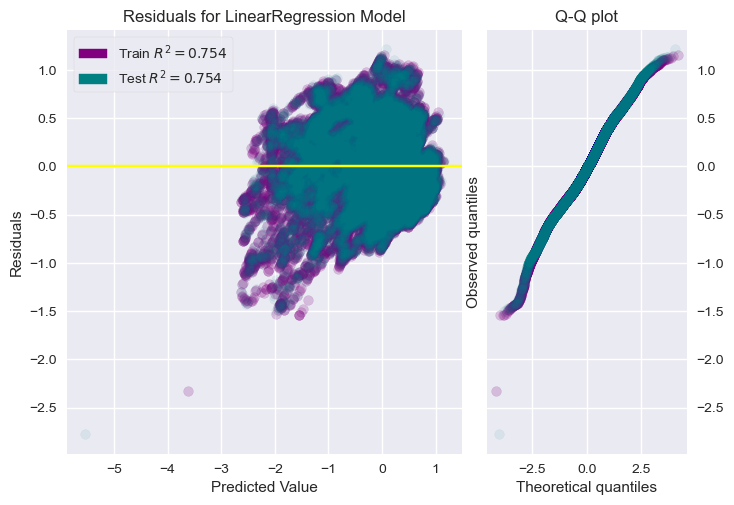

multivariate regression R2:  0.7535274426373272
multivariate regression mean squared error:  0.1416143759945514


In [321]:
# Residual plot with the best performing model
plt.style.use('seaborn')
from yellowbrick.regressor import ResidualsPlot

test_size = 0.35 # best performing test set proportions
mrxtrain, mrxtest, mrytrain, mrytest = train_test_split(mr[:, 0:3], mr[:, -1], test_size=test_size, random_state=10)


# initialising regression model

mlr = LinearRegression()

# initialising residual plot

visualiser = ResidualsPlot(mlr, hist = False, qqplot = True, train_color = 'purple', test_color = 'teal',\
                          line_color = 'yellow', train_alpha = 0.2, test_alpha = 0.08)

# fitting the model and subsequently the visualiser
visualiser.fit(mrxtrain, mrytrain)
visualiser.score(mrxtest, mrytest)

visualiser.show()

mlr.fit(mrxtrain, mrytrain.reshape(-1, 1))
mrpreds = mlr.predict(mrxtest)

print('multivariate regression R2: ', r2(mrytest, mrpreds))
print('multivariate regression mean squared error: ', mse(mrytest, mrpreds))

In [107]:
preds2 = []
for each in mrpreds:
    for i in each:
        preds2.append(i)

In [108]:
len(preds2)

25880

In [109]:
mrytest2 = mrytest.tolist()

In [110]:
len(mrytest2)

25880

In [111]:
residslist = []
for i in range(0, len(mrytest)):
    residslist.append(mrytest2[i] - preds2[i])

In [112]:
len(residslist)

25880

Text(0, 0.5, 'Residuals')

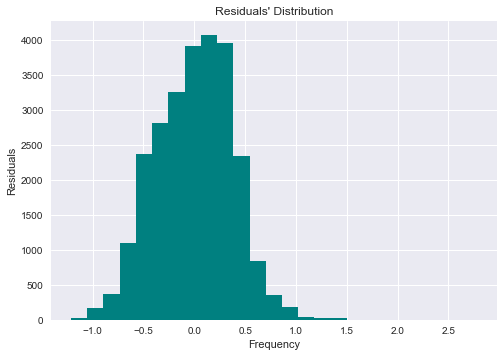

In [121]:
plt.hist(residslist, bins = 25, color = 'teal')
plt.title("Residuals' Distribution")
plt.xlabel('Frequency')
plt.ylabel('Residuals')